In [42]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn

from collections import defaultdict
import numpy as np
import torch
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.convert_parameters import parameters_to_vector

import matplotlib.pyplot as plt

# import time
from torch.func import functional_call, jacrev
from torch.distributions.multivariate_normal import _precision_to_scale_tril

from custom_laplace import Subnet

## Hyperparams

In [43]:
torch.random.manual_seed(113311)
np.random.seed(113311)

In [44]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [45]:
from hyperparams import (
    lr,
    acquisition_batch_size,
    train_batch_size,
    num_train,
    num_pool,
)

pool_batch_size = 1
count_subnet = 1000
sigma_noise = 1.0
temperature = 1.0

epochs = 25  # training epochs
num_epochs_variance_train = 10

In [46]:
H_factor = 1 / (sigma_noise**2) / temperature

## Model Definition

In [47]:
from model import Net

## Helper Functions

In [48]:
def train(model_, train_loader, optimizer):
    model_.train()
    avg_loss = 0
    epoch_size = 0
    for _, (data, target) in enumerate(train_loader):
        epoch_size += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model_(data)
        loss = F.cross_entropy(output, target)
        avg_loss += loss
        loss.backward()
        optimizer.step()
    return avg_loss / epoch_size

In [49]:
def test(model_, test_loader):
    model_.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model_(data)
            test_loss += F.cross_entropy(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return correct, test_loss

In [50]:
def print_losses(epoch, train_loss, test_loss, correct, total):
    test_accuracy = correct / float(total)
    print(
        "For epoch {}: Train - Avg loss: {:.4f}; Test - Avg loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            epoch, train_loss, test_loss, correct, total, 100.0 * test_accuracy
        )
    )

In [51]:
def hasnan(x):
    return torch.isnan(x).any()

In [52]:
def remove_occurrences_from_list(l, items):
    return list(
        np.setdiff1d(
            np.array(l, dtype=int), np.array(items, dtype=int), assume_unique=True
        )
    )

In [53]:
def move_data(indices, from_subset, to_subset):
    from_subset.indices = remove_occurrences_from_list(from_subset.indices, indices)
    if isinstance(to_subset.indices, list):
        to_subset.indices.extend(indices)
    elif isinstance(to_subset.indices, np.ndarray):
        to_subset.indices = np.concatenate([to_subset.indices, np.array(indices)])

## Variable Definitions

In [54]:
dataset = datasets.CIFAR10(
    "data", train=True, download=True, transform=transforms.ToTensor()
)

classes = dataset.classes

train_size = int(0.90 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

test_dataset = datasets.CIFAR10(
    "data", train=False, download=True, transform=transforms.ToTensor()
)
len(dataset), len(train_dataset), len(test_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 45000, 10000)

In [55]:
num_classes = len(classes)
samples_per_class = (num_train) // num_classes

class_indices = defaultdict(list)

for idx, (_, target) in enumerate(train_dataset):
    class_indices[target].append(idx)

for indices in class_indices.values():
    np.random.shuffle(indices)

train_indices = []

# get samples_per_class for all classes
for indices in class_indices.values():
    till = min(len(indices), samples_per_class)
    train_indices.extend(indices[:till])

np.random.shuffle(train_indices)

In [56]:
all_indices = np.arange(len(train_dataset))
remaining_indices = np.setdiff1d(all_indices, train_indices)
pool_indices = np.random.choice(remaining_indices, size=num_pool, replace=False)
len(pool_indices), len(remaining_indices)

(10000, 44800)

In [57]:
common_elements = np.intersect1d(train_indices, pool_indices)
num_common_elements = len(common_elements)
print(f"Number of common elements: {num_common_elements}")

Number of common elements: 0


In [58]:
pretrain_dataset = torch.utils.data.Subset(dataset, train_indices)
pool_dataset = torch.utils.data.Subset(dataset, pool_indices)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True
)

In [59]:
pretrain_loader = torch.utils.data.DataLoader(
    pretrain_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True
)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
subnet = Subnet(model, snapshot_freq=1, count_params_subnet=count_subnet)

In [60]:
total = len(val_dataset)

for epoch in range(epochs - num_epochs_variance_train):
    train_loss = train(model, pretrain_loader, optimizer)
    correct, test_loss = test(model, val_loader)
    print_losses(epoch, train_loss, test_loss, correct, total)

print("Starting variance training for subnet selection")
for epoch in range(num_epochs_variance_train):
    train_loss = train(model, pretrain_loader, optimizer)
    correct, test_loss = test(model, val_loader)
    print_losses(epoch, train_loss, test_loss, correct, total)
    subnet.update_model_variances(epoch, epochs)

correct, test_loss = test(model, test_loader)
print(f"Test loss: {test_loss}; Accuracy {correct}/{len(test_dataset)}")

For epoch 0: Train - Avg loss: 2.3122; Test - Avg loss: 2.3047, Accuracy: 500/5000 (10%)
For epoch 1: Train - Avg loss: 2.2777; Test - Avg loss: 2.3142, Accuracy: 500/5000 (10%)
For epoch 2: Train - Avg loss: 2.2666; Test - Avg loss: 2.3543, Accuracy: 559/5000 (11%)
For epoch 3: Train - Avg loss: 2.3130; Test - Avg loss: 2.3149, Accuracy: 506/5000 (10%)
For epoch 4: Train - Avg loss: 2.2789; Test - Avg loss: 2.3063, Accuracy: 557/5000 (11%)
For epoch 5: Train - Avg loss: 2.2948; Test - Avg loss: 2.3098, Accuracy: 463/5000 (9%)
For epoch 6: Train - Avg loss: 2.2653; Test - Avg loss: 2.3141, Accuracy: 506/5000 (10%)
For epoch 7: Train - Avg loss: 2.2363; Test - Avg loss: 2.3621, Accuracy: 507/5000 (10%)
For epoch 8: Train - Avg loss: 2.3057; Test - Avg loss: 2.3386, Accuracy: 507/5000 (10%)
For epoch 9: Train - Avg loss: 2.2644; Test - Avg loss: 2.3085, Accuracy: 739/5000 (15%)
For epoch 10: Train - Avg loss: 2.2812; Test - Avg loss: 2.3082, Accuracy: 580/5000 (12%)


KeyboardInterrupt: 

In [ ]:
torch.save(model, "./tmp/model_ppd.pth")

In [ ]:
model = torch.load("./tmp/model_ppd.pth")
test(model, test_loader)

(2374, 2.110188164138794)

In [ ]:
def generate_dicts(model):
    params_dict = {k: v for k, v in model.named_parameters() if v.requires_grad}
    buffers_dict = {k: v for k, v in model.named_buffers()}

    params_dict = {key: value.to(device) for key, value in params_dict.items()}
    buffers_dict = {key: value.to(device) for key, value in buffers_dict.items()}
    return params_dict, buffers_dict

In [ ]:
# X, _ = next(iter(val_loader))

# with torch.no_grad():
#     try:
#         out = model(X[:1].to(device))
#     except (TypeError, AttributeError):
#         out = model(X.to(device))

# n_outputs = out.shape[-1]
# setattr(model, "output_size", n_outputs)

In [ ]:
def entropy(x, eps=1e-6):
    return -(x + eps) * torch.log(x + eps)

In [ ]:
def jacobians(x, params_dict, buffers_dict, subnet_mask_indices):
    def model_fn_params_only(params_dict, buffers_dict):
        out = functional_call(model, (params_dict, buffers_dict), x)
        return out, out

    with torch.no_grad():
        Js, f = jacrev(model_fn_params_only, has_aux=True)(params_dict, buffers_dict)

    Js = [
        j.flatten(start_dim=-p.dim()) for j, p in zip(Js.values(), params_dict.values())
    ]
    Js = torch.cat(Js, dim=-1)

    Js = Js[:, :, subnet_mask_indices]
    return Js, f

In [ ]:
def ppd_score(ppd):
    # I(y;W | x) = H1 - H2 = H(y|x) - E_w[H(y|x,W)]
    H1 = entropy(ppd).sum(axis=1)
    return H1

In [ ]:
def select_batch(model, pool_data, subnet_mask_indices, posterior_covariance):
    pool_loader = torch.utils.data.DataLoader(
        pool_data, batch_size=pool_batch_size, pin_memory=True, shuffle=False
    )
    params_dict, buffers_dict = generate_dicts(model)

    def calculate_ppd(X):
        Js, f_mu = jacobians(X, params_dict, buffers_dict, subnet_mask_indices)
        Js = Js.squeeze(0)
        f_var = torch.einsum("np,pq,mq->nm", Js, posterior_covariance, Js)
        f_var = f_var.unsqueeze(0)
        kappa = 1 / torch.sqrt(1.0 + torch.pi / 8 * f_var.diagonal(dim1=1, dim2=2))
        final_ppd = torch.softmax(kappa * f_mu, dim=-1)
        return final_ppd

    scores = torch.zeros(len(pool_data)).to(device)
    for batch_idx, (data, _) in enumerate(pool_loader):
        end_idx = batch_idx + data.shape[0]
        ppd = calculate_ppd(data.to(device))
        scores[batch_idx:end_idx] = ppd_score(ppd)

    best_local_indices = torch.argsort(scores, descending=True)[:acquisition_batch_size]
    best_global_indices = np.array(pool_data.indices)[best_local_indices.cpu().numpy()]
    return best_global_indices

In [ ]:
def get_posterior_covariance(H):
    prior_precision_diag = torch.ones(count_subnet, device=device)
    # prior with lambda = 1
    posterior_precision = H_factor * H + torch.diag(prior_precision_diag)
    invsqrt_precision = _precision_to_scale_tril
    posterior_scale = invsqrt_precision(posterior_precision)
    posterior_covariance = posterior_scale @ posterior_scale.T
    return posterior_covariance


def calculate_ggn(model, train_dataset, subnet_mask_indices):
    params_dict, buffers_dict = generate_dicts(model)
    H = torch.zeros(count_subnet, count_subnet, device=device)
    loss = 0.0
    lossfunc = nn.CrossEntropyLoss(reduction="sum")
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, pin_memory=True, shuffle=True
    )
    for X, y in train_loader:
        model.zero_grad()
        X, y = X.to(device), y.to(device)
        Js, f = jacobians(X, params_dict, buffers_dict, subnet_mask_indices)
        ps = torch.softmax(f, dim=-1)
        H_lik = torch.diag_embed(ps) - torch.einsum("mk,mc->mck", ps, ps)
        H_batch = torch.einsum("bcp,bck,bkq->pq", Js, H_lik, Js)
        loss_batch = 1.0 * lossfunc(f, y)
        loss += loss_batch
        H += H_batch
    posterior_covariance = get_posterior_covariance(H)
    return posterior_covariance

In [61]:
test_accuracies = []
acq_num = 1
acc_test = 0.0
train_dataset = pretrain_dataset

# start with a pretrained model on the pretraining data
# also should have obtained the subnet
while len(pool_dataset) > 0 and acc_test <= 0.58 and acq_num <= 30:
    # train on it
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, pin_memory=True, shuffle=True
    )
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer)
        correct, test_loss = test(model, val_loader)
        print_losses(epoch, train_loss, test_loss, correct, len(val_dataset))
        subnet.update_model_variances(epoch, epochs)

    # test the accuracy
    correct, test_loss = test(model, test_loader)
    acc_test = correct / len(test_dataset)
    test_accuracies.append(acc_test)
    print(f"Test loss: {test_loss}; Accuracy {correct}/{len(test_dataset)}")

    subnet_mask_indices = subnet.get_mask_indices()
    params_dict, buffers_dict = generate_dicts(model)
    posterior_covariance = calculate_ggn(model, train_dataset, subnet_mask_indices)

    print(f"Acquiring BALD batch. acq_num: {acq_num} Pool size: {len(pool_dataset)}")
    # get the indices of the best batch of data
    start_time = time.time()
    batch_indices = select_batch(
        model, pool_dataset, subnet_mask_indices, posterior_covariance
    )
    end_time = time.time()
    print(f"Time taken for acquisition score computation: {end_time - start_time}")

    # move that data from the pool to the training set
    move_data(batch_indices, pool_dataset, train_dataset)

    acq_num = acq_num + 1

For epoch 0: Train - Avg loss: 2.3125; Test - Avg loss: 2.3022, Accuracy: 697/5000 (14%)
For epoch 1: Train - Avg loss: 2.2913; Test - Avg loss: 2.3011, Accuracy: 735/5000 (15%)
For epoch 2: Train - Avg loss: 2.2943; Test - Avg loss: 2.3010, Accuracy: 633/5000 (13%)
For epoch 3: Train - Avg loss: 2.2607; Test - Avg loss: 2.3005, Accuracy: 736/5000 (15%)
For epoch 4: Train - Avg loss: 2.2083; Test - Avg loss: 2.3139, Accuracy: 506/5000 (10%)
For epoch 5: Train - Avg loss: 2.2500; Test - Avg loss: 2.2776, Accuracy: 708/5000 (14%)
For epoch 6: Train - Avg loss: 2.2381; Test - Avg loss: 2.2536, Accuracy: 752/5000 (15%)
For epoch 7: Train - Avg loss: 2.2097; Test - Avg loss: 2.2287, Accuracy: 901/5000 (18%)
For epoch 8: Train - Avg loss: 2.2049; Test - Avg loss: 2.2329, Accuracy: 840/5000 (17%)
For epoch 9: Train - Avg loss: 2.1574; Test - Avg loss: 2.2221, Accuracy: 860/5000 (17%)
For epoch 10: Train - Avg loss: 2.1075; Test - Avg loss: 2.2205, Accuracy: 874/5000 (17%)
For epoch 11: Train 

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 12.38 MiB is free. Including non-PyTorch memory, this process has 3.48 GiB memory in use. Process 327155712 has 0 bytes memory in use. Of the allocated memory 3.05 GiB is allocated by PyTorch, and 319.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [64]:
import pickle as pk

with open("./tmp/test_accuracies_ppd2.pickle", "wb") as f:
    pk.dump(test_accuracies, f)

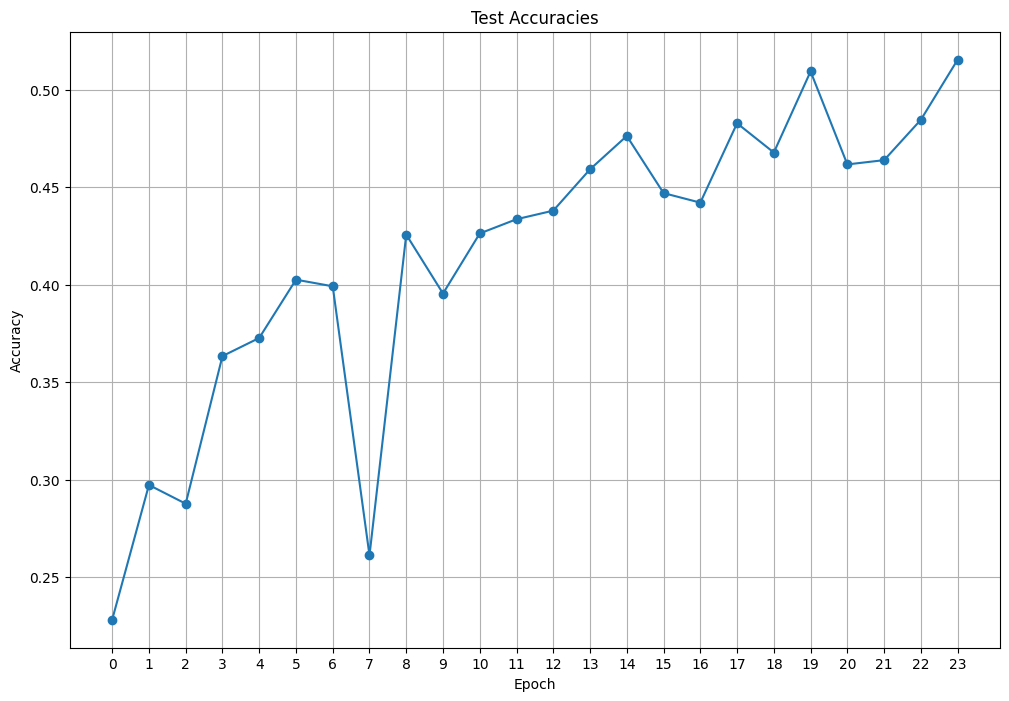

In [65]:
epochs = range(0, len(test_accuracies))

plt.figure(figsize=(12, 8))
plt.plot(epochs, test_accuracies, marker="o")
plt.title("Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.grid(True)
plt.show()